In [1]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


# Using `poppy`'s ThinLens, ZernikeWFE, and ParameterizedWFE classes

This notebook will show you three different ways to introduce defocus in your model optical system, as well as some of the additional flexibility afforded by the `ZernikeWFE` and `ParameterizedWFE` classes.

First off, we import `poppy` and define some useful constants. We're going to use 460 nm light through a 1 meter circular aperture.

In [2]:
import poppy

In [3]:
RADIUS = 1.0 # meters
WAVELENGTH = 460e-9 # meters
PIXSCALE = 0.01 # arcsec / pix
FOV = 1 # arcsec
NWAVES = 1.0

# Visualizing the PSF without any defocus

This is just about the simplest optical system we can make. Light illuminates a circular pupil, and is imaged onto a detector.

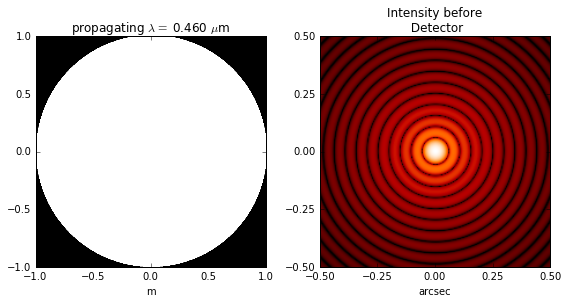

In [4]:
osys = poppy.OpticalSystem()
circular_aperture = poppy.CircularAperture(radius=RADIUS)
osys.addPupil(circular_aperture)
osys.addDetector(pixelscale=PIXSCALE, fov_arcsec=FOV)

plt.figure(figsize=(8, 8))
psf = osys.calcPSF(wavelength=WAVELENGTH, display_intermediates=True)
plt.tight_layout()

Ahh, a nice Airy function. This is a monochromatic PSF at `WAVELENGTH` (460 nm).

The `ThinLens` optic lets us introduce defocus specified as number of waves. One wave of defocus means that the maximum of the Airy disk becomes a minimum, with a lot of intensity pushed out into a "donut" around the center of the PSF.

# Adding a Thin Lens

Let's add a `ThinLens` in the code to create our optical system. We're going to use 1 wave of defocus, and the same reference wavelength as we're using to calculate our monochromatic psf.

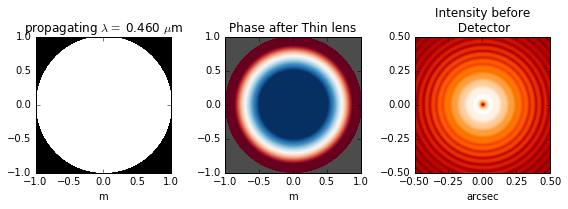

In [5]:
osys = poppy.OpticalSystem()
circular_aperture = poppy.CircularAperture(radius=RADIUS)
osys.addPupil(circular_aperture)

thinlens = poppy.ThinLens(nwaves=NWAVES, reference_wavelength=WAVELENGTH, radius=RADIUS)
osys.addPupil(thinlens)

osys.addDetector(pixelscale=PIXSCALE, fov_arcsec=FOV)

plt.figure(figsize=(8, 8))
psf = osys.calcPSF(wavelength=WAVELENGTH, display_intermediates=True)
plt.tight_layout()

Introducing defocus is just one type of aberration you might want to model. `ThinLens` is a separate class because it allows you to specify defocus in waves relative to a reference wavelength rather than RMS wavefront error. Both techniques are useful, but the specifications for JWST NIRCam are delivered in such a way that it makes sense to implement `ThinLens` in this way. (Just one artifact of POPPY's connection to JWST!)

Let's get familiar with `ThinLens`'s big brother, `ZernikeWFE`.

# Reproducing the ThinLens behavior with the ZernikeWFE

ZernikeWFE lets us specify a sequence of scaling coefficients for the Zernike basis functions, which are then summed to make a model optical element in our `OpticalSystem` with that behavior. The sequence corresponds to the [Noll indexing convention](https://en.wikipedia.org/wiki/Zernike_polynomials#Zernike_polynomials) for 1-D Zernike polynomial indices. The first (or "zeroth") element of the sequence is the coefficient for $Z_{j=1}$, the second for $Z_{j=2}$, and so on.

The Noll index for the defocus term, $Z_2^0$, is $Z_{j=4}$.

Whereas `ThinLens` uses a number of waves, the scaling coefficients for `ZernikeWFE` are with respect to the normalized RMS wavefront error of 1.0 meters. That would be a huge optical path difference, so coefficients will typically be on the order of the wavelength (expressed in meters).

The normalization of ZernikeWFE introduces a factor of $2 \sqrt{3}$, so we calculate our coefficient as:

$$k = \frac{\mathrm{N_{waves}} \lambda}{2\sqrt{3}} .$$

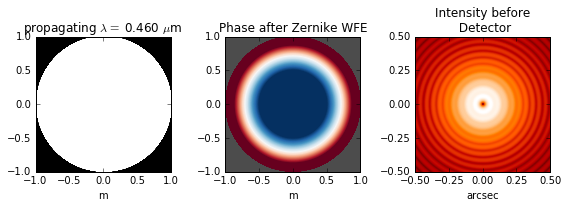

In [6]:
defocus_coefficient = NWAVES * WAVELENGTH / (2 * np.sqrt(3))
coefficients_sequence = [0, 0, 0, defocus_coefficient]

osys = poppy.OpticalSystem()
circular_aperture = poppy.CircularAperture(radius=RADIUS)
osys.addPupil(circular_aperture)
thinlens = poppy.ZernikeWFE(radius=RADIUS, coefficients=coefficients_sequence)
osys.addPupil(thinlens)
osys.addDetector(pixelscale=PIXSCALE, fov_arcsec=FOV)

plt.figure(figsize=(8,8))
psf_with_zernikewfe = osys.calcPSF(wavelength=WAVELENGTH, display_intermediates=True)
plt.tight_layout()

## Compare the two PSFs

To ensure we've got agreement between the two methods, `poppy.display_PSF_difference` will show any discrepancies.

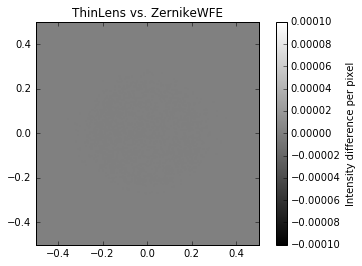

In [7]:
poppy.display_PSF_difference(psf, psf_with_zernikewfe, title='ThinLens vs. ZernikeWFE')

# Adding some tilt and astigmatism

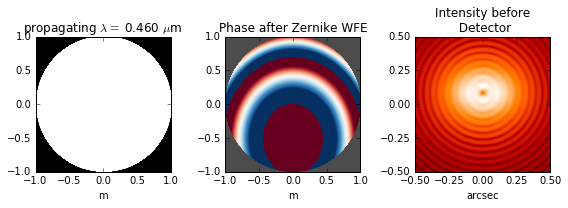

In [8]:
coefficients_sequence = [0, 0, 2e-7, defocus_coefficient, 0, 3e-8]

osys = poppy.OpticalSystem("Testing Thin Lens w/ Zernike Module")
circular_aperture = poppy.CircularAperture(radius=RADIUS)
osys.addPupil(circular_aperture)
thinlens = poppy.ZernikeWFE(radius=RADIUS, coefficients=coefficients_sequence)
osys.addPupil(thinlens)
osys.addDetector(pixelscale=PIXSCALE, fov_arcsec=FOV)

plt.figure(figsize=(8,8))
psf_with_astigmatism = osys.calcPSF(wavelength=WAVELENGTH, display_intermediates=True)
plt.tight_layout()

# Can we accomplish the same thing with `ParameterizedWFE`?

`ParameterizedWFE` lets us specify optical aberrations in terms of a linear combination of basis functions evaluated over the pupil. This is more general than the `ZernikeWFE`, which specifies that you must use the Zernike basis functions to represent the distortion, but we can use `ParameterizedWFE` in an equivalent way if we wish.

To specify which basis we want, we supply a `basis_factory` argument. This is a callable (e.g. a function) that gets keyword arguments `nterms` and `npix`, and returns an `nterms` by `npix` by `npix` array containing the first `nterms` terms evaluated over a pupil circumscribed by a circle of diameter `npix`.

Two useful basis functions are provided in `poppy.zernike`: `zernike_basis` and `hexike_basis`. The `zernike_basis` allows us to provide equivalent functionality to `ZernikeWFE`, if we wish. Here's what that would look like:

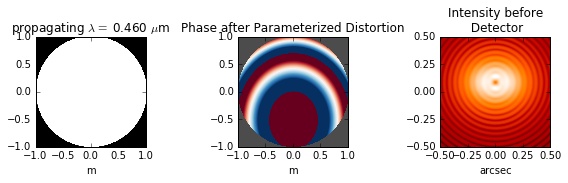

In [9]:
osys = poppy.OpticalSystem()
circular_aperture = poppy.CircularAperture(radius=RADIUS)
osys.addPupil(circular_aperture)
thinlens = poppy.ParameterizedWFE(
    coefficients=coefficients_sequence,
    basis_factory=poppy.zernike.zernike_basis,
    radius=RADIUS
)
osys.addPupil(thinlens)
osys.addDetector(pixelscale=PIXSCALE, fov_arcsec=FOV)

plt.figure(figsize=(8,8))
psf_with_parameterizedwfe = osys.calcPSF(wavelength=WAVELENGTH, display_intermediates=True)
plt.tight_layout()

# What else is `ParameterizedWFE` good for?

The ability to specify `basis_factory` means that we're not limited to Zernike polynomials. Suppose we have a telescope with a hexagonal pupil? The correct way to specify Zernike-like aberrations in an orthonormal basis on the unit hexagon is with "hexikes", a modified Zernike basis.

Hexikes are computed by `poppy.zernike.hexike_basis`, which we pass in (along with the same coefficients as before) to get an idea of how the hexagon aperture changes things:

/Users/jlong/homebrew/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/colors.py:1018: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


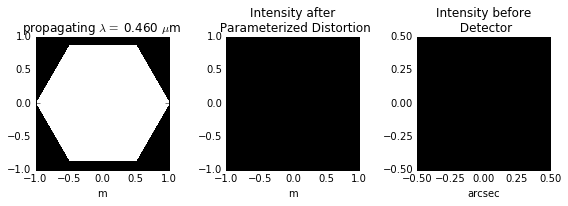

In [10]:
osys = poppy.OpticalSystem()
hex_aperture = poppy.HexagonAperture(side=RADIUS)
osys.addPupil(hex_aperture)
thinlens = poppy.ParameterizedWFE(
    coefficients=coefficients_sequence,
    basis_factory=poppy.zernike.hexike_basis,
    radius=RADIUS
)
osys.addPupil(thinlens)
osys.addDetector(pixelscale=PIXSCALE, fov_arcsec=FOV)

plt.figure(figsize=(8,8))
psf_with_hexikes = osys.calcPSF(wavelength=WAVELENGTH, display_intermediates=True)
plt.tight_layout()

# Scriptability of `ZernikeWFE`

The API for `ZernikeWFE` also lends itself well to generating coefficients programmatically and passing it in. Say we have an error budget where we know the following about the RMS wavefront error in the Zernike components:

  * **Piston**, *j=1* — disregarded for a telescope
  * **Tilt X**, *j=2* — $\pm$ 100 nm
  * **Tilt Y**, *j=3* — $\pm$ 100 nm
  * **Focus**, *j=4* — $\pm$ 50 nm
  * **Astigmatism 45**, *j=5* — $\pm$ 36 nm
  * **Astigmatism 0**, *j=6* — $\pm$ 36 nm

We can use `ZernikeWFE` to generate a library of sample PSFs satisfying this error budget. First, we write a short function that can generate coefficients from our specifications.

In [11]:
wfe_budget = [0, 100, 100, 50, 36, 36]

def generate_coefficients(wfe_budget):
    coefficients = []
    for term in wfe_budget:
        coefficients.append(
            np.random.uniform(low=-1e-9 * term, high=1e-9 * term)  # convert nm to meters, get value in range
        )
    return coefficients

Now we use this to generate a few sets of coefficients.

In [12]:
possible_coefficients = [generate_coefficients(wfe_budget) for i in range(5)]

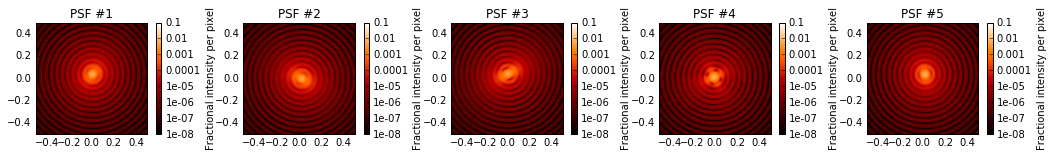

In [13]:
plt.figure(figsize=(18,2))

for idx, coefficient_set in enumerate(possible_coefficients, start=1):
    plt.subplot(1, 5, idx)

    osys = poppy.OpticalSystem()
    hex_aperture = poppy.CircularAperture(radius=RADIUS)
    osys.addPupil(hex_aperture)
    thinlens = poppy.ZernikeWFE(
        coefficients=coefficient_set,
        radius=RADIUS
    )
    osys.addPupil(thinlens)
    osys.addDetector(pixelscale=PIXSCALE, fov_arcsec=FOV)

    psf = osys.calcPSF(wavelength=WAVELENGTH, display=False)
    poppy.display_PSF(psf, title="PSF #{}".format(idx))